In [21]:
import numpy as np
import tensorflow as tf
import pandas as pd
import json
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# Load the label map
with open('/content/drive/MyDrive/land-use-classification/data/label_map.json', 'r') as f:
    label_map = json.load(f)

In [3]:
# Define the paths to the image directories and CSV files
train_dir = '/content/drive/MyDrive/land-use-classification/data/images_train_test_val/train'
val_dir = '/content/drive/MyDrive/land-use-classification/data/images_train_test_val/validation'
test_dir = '/content/drive/MyDrive/land-use-classification/data/images_train_test_val/test'

train_csv = '/content/drive/MyDrive/land-use-classification/data/train.csv'
val_csv = '/content/drive/MyDrive/land-use-classification/data/validation.csv'
test_csv = '/content/drive/MyDrive/land-use-classification/data/test.csv'

In [4]:
# Load the CSV files into Pandas dataframes
train_df = pd.read_csv(train_csv)
val_df = pd.read_csv(val_csv)
test_df = pd.read_csv(test_csv)

In [5]:
# Define the image size and batch size
IMG_SIZE = 256
BATCH_SIZE = 32

In [33]:
# Augment training data
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

# Define image data generators using ImageDataGenerator
train_generator = train_datagen.flow_from_dataframe(train_df,
                                                    directory=train_dir,
                                                    x_col='Filename',
                                                    y_col='ClassName',
                                                    target_size=(IMG_SIZE, IMG_SIZE),
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='categorical')

val_datagen = ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow_from_dataframe(val_df,
                                                directory=val_dir,
                                                x_col='Filename',
                                                y_col='ClassName',
                                                target_size=(IMG_SIZE, IMG_SIZE),
                                                batch_size=BATCH_SIZE,
                                                class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(test_df,
                                                  directory=test_dir,
                                                  x_col='Filename',
                                                  y_col='ClassName',
                                                  target_size=(IMG_SIZE, IMG_SIZE),
                                                  batch_size=BATCH_SIZE,
                                                  class_mode='categorical',
                                                  shuffle=False)

Found 7350 validated image filenames belonging to 21 classes.
Found 2100 validated image filenames belonging to 21 classes.
Found 1050 validated image filenames belonging to 21 classes.


In [7]:
# Define a baseline CNN model
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(len(label_map), activation='softmax')
])

In [8]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
# Fit the model
history = model.fit(train_generator,
                    steps_per_epoch=len(train_df)//BATCH_SIZE,
                    epochs=20,
                    validation_data=val_generator,
                    validation_steps=len(val_df)//BATCH_SIZE)

Epoch 1/20
229/229 [==============================] - 3619s 16s/step - loss: 2.7570 - accuracy: 0.1369 - val_loss: 2.3796 - val_accuracy: 0.2587
Epoch 2/20
229/229 [==============================] - 143s 626ms/step - loss: 2.1510 - accuracy: 0.3084 - val_loss: 1.8783 - val_accuracy: 0.3846
Epoch 3/20
229/229 [==============================] - 143s 626ms/step - loss: 1.7985 - accuracy: 0.4091 - val_loss: 1.5487 - val_accuracy: 0.4827
Epoch 4/20
229/229 [==============================] - 144s 627ms/step - loss: 1.5314 - accuracy: 0.5020 - val_loss: 1.2522 - val_accuracy: 0.5865
Epoch 5/20
229/229 [==============================] - 140s 611ms/step - loss: 1.3218 - accuracy: 0.5630 - val_loss: 1.1916 - val_accuracy: 0.6111
Epoch 6/20
229/229 [==============================] - 142s 622ms/step - loss: 1.2305 - accuracy: 0.5864 - val_loss: 0.9751 - val_accuracy: 0.6635
Epoch 7/20
229/229 [==============================] - 138s 601ms/step - loss: 1.0985 - accuracy: 0.6341 - val_loss: 0.8936 - 

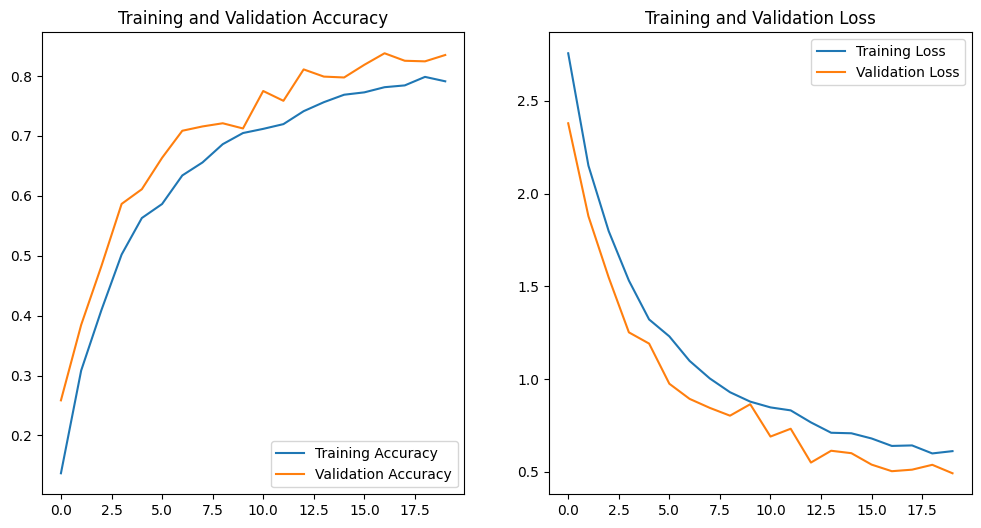

In [14]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [34]:
test_loss, test_acc = model.evaluate(test_generator, steps=len(test_df)//BATCH_SIZE)
print('Test accuracy:', test_acc)

32/32 [==============================] - 9s 272ms/step - loss: 0.4972 - accuracy: 0.8291
Test accuracy: 0.8291015625
